In [2]:
from pathlib import Path
import os
from BNS_JT import variable, cpm
import batch
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx
from matplotlib.lines import Line2D
import pickle
import time
from scipy.stats import multivariate_normal
import heapq

HOME = Path(os.getcwd())
output_path = HOME / "output"

cfg = batch.config_custom("input/config.json", 's1')
node_coords = {}
for k, v in cfg.infra['nodes'].items():
    node_coords[k] = (v['pos_x'], v['pos_y'])

arcs = {}
for k, v in cfg.infra['edges'].items():
    arcs[k] = [v['origin'], v['destination']]

epi_loc = cfg.infra['eq']['s1']['epicentre']
os_list = cfg.infra['origins']

scenario to be added later


In [3]:
key = 'n30'
with open( output_path / f"cpms_{key}.pk", 'rb') as f:
    cpms = pickle.load(f)

cpm_node = cpms[key]
print(sum([1 if c[0]==2 else 0 for c in cpm_node.C]))

22792


In [4]:
key = 'n30'
#key = 'n73'
fout_rules = output_path.joinpath(f'rules_{key}.pk')
with open(fout_rules, 'rb') as file:
    rules = pickle.load(file)

rs_short = heapq.nsmallest(5, rules['s'], key=len)
rf_short = heapq.nsmallest(5, rules['f'], key=len)

print(rs_short)
print(rf_short)

print(len(rules['s']), len(rules['f']))

[{'e59': 1, 'e46': 1, 'e40': 1}, {'e36': 1, 'e35': 1, 'e38': 1}, {'e60': 1, 'e117': 1, 'e125': 1}, {'e60': 1, 'e116': 1, 'e123': 1, 'e125': 1}, {'e59': 1, 'e62': 1, 'e117': 1, 'e125': 1}]
[{'e36': 0, 'e59': 0, 'e60': 0}, {'e22': 0, 'e35': 0, 'e59': 0, 'e60': 0}, {'e36': 0, 'e46': 0, 'e60': 0, 'e61': 0, 'e62': 0}, {'e36': 0, 'e59': 0, 'e62': 0, 'e65': 0, 'e68': 0, 'e125': 0}, {'e22': 0, 'e35': 0, 'e46': 0, 'e60': 0, 'e61': 0, 'e62': 0}]
29 10


Plot failure-probability map

In [5]:
def draw_pf_map(node_coords, node_pfs, arcs, epi_loc, os_list, Mw, fig_name, is_legend, is_cmap, margin):

    coords_list = []
    pfs_list = []
    for k, v in node_coords.items():
        if k in node_pfs:
            coords_list.append(v)
            pfs_list.append(node_pfs[k])

    x_coords = [coord[0] for coord in coords_list]
    y_coords = [coord[1] for coord in coords_list]

    plt.figure()
    grid_x, grid_y = np.mgrid[min(x_coords):max(x_coords):100j, min(y_coords):max(y_coords):100j]
    grid_z = griddata(coords_list, pfs_list, (grid_x, grid_y), method='linear')

    # Create a color map using imshow
    im = plt.imshow(grid_z.T, norm=colors.LogNorm(vmin = 1.0e-12, vmax = 1.0), extent=(min(x_coords), max(x_coords), min(y_coords), max(y_coords)),
            origin='lower', cmap='inferno')

    f_size = 15    
    if is_cmap:
        cbar = plt.colorbar(im, shrink=0.8) 
        font_style = {'size': f_size, 'family': 'Times New Roman'}
        cbar.set_label('Failure probability', fontdict = font_style)
        tick_labels = cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)

    # Graph
    G = nx.Graph()
    for k, v in node_coords.items():
        G.add_node(k, pos=v)
    for k,v in arcs.items():
        G.add_edge(v[0], v[1])
    G.add_node('epi', pos=epi_loc)
    node_coords['epi'] = epi_loc

    # Draw the graph
    nx.draw(G, node_coords, nodelist = [n for n in node_coords if n != 'epi'], node_color='k', edge_color='w', node_size=5)

    ## Origin nodes
    nx.draw_networkx_nodes(G, node_coords, nodelist=os_list, node_color='b', node_size=100, node_shape='*' )
    ## Epicentre
    nx.draw_networkx_nodes(G, node_coords, nodelist = ['epi'], node_color='r', node_size=50, node_shape='x')

    ## Legend
    if is_legend:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Node',
                                markerfacecolor='k', markersize=5),
                        Line2D([0], [0], marker='*', color='w', label='Origin',
                                markerfacecolor='b', markersize=10),
                        Line2D([0], [0], marker='x', color='w', label='Epicentre',
                                markeredgecolor='r', markersize=6)]
        font_style_l = {'size': f_size, 'family': 'Times New Roman'}
        plt.legend(handles=legend_elements, loc=[-0.15,0.8], prop=font_style_l, handletextpad=0.00001)

    plt.subplots_adjust(left=margin[0], right=margin[1], top=margin[2], bottom=margin[3])
    plt.savefig(fig_name, dpi=500)

    # Show the plot
    %matplotlib inline
    plt.show()

In [6]:
node_pfs, nsamps = {}, {}
with open(output_path / "result.txt") as f:
    for line in f:
        node, pf_low, pf_up, nsamp, cov = line.strip().split("\t")
        node_pfs[node], nsamps[node] = float(pf_low), int(nsamp)

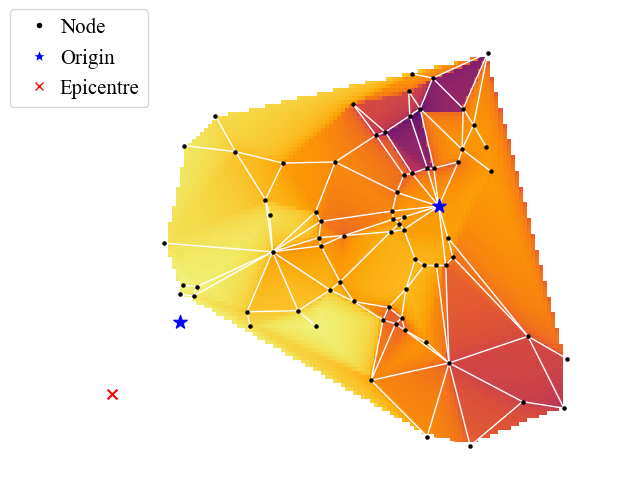

In [7]:
draw_pf_map(node_coords, node_pfs, arcs, epi_loc, os_list, cfg.infra['eq']['s1']['Mw'], 'pf_map1.png', is_legend=True, is_cmap=False, margin=[-0.2, 1.3, 0.99, 0.0])

In [8]:
print(min(node_pfs.values()), max(node_pfs.values()))

keys_less_than_threshold = [key for key, value in node_pfs.items() if value < 10**-10]
print(keys_less_than_threshold)

7.6929e-11 0.3918
['n6']


Draw results on computation costs

In [9]:
s_nrules, f_nrules, nbrs, nfuns, brc_times = {}, {}, {}, {}, {}
for node in node_coords:
    if node != 'epi' and node not in os_list:
        with open( output_path / f"brc_{node}.pk", 'rb') as f:
            monitor = pickle.load(f)
            s_nrules[node], f_nrules[node] = int(monitor['r_s_ns'][-1]), int(monitor['r_f_ns'][-1])
            nbrs[node], nfuns[node], brc_times[node] = int(monitor['br_s_ns'][-1]+monitor['br_f_ns'][-1]+monitor['br_u_ns'][-1]), len(monitor['sf_ns']), sum(monitor['time'])

mcs_times = {}
for node in node_coords:
    if node != 'epi' and node not in os_list:
        if nsamps[node] > 0:
            with open( output_path / f"rs_{node}.txt", 'r') as f:
                lines=f.readlines()
            l4 = lines[3]
            sec = l4.split('\t')
            mcs_times[node] = float(sec[1])


In [10]:
import matplotlib as mpl

<Figure size 640x480 with 0 Axes>

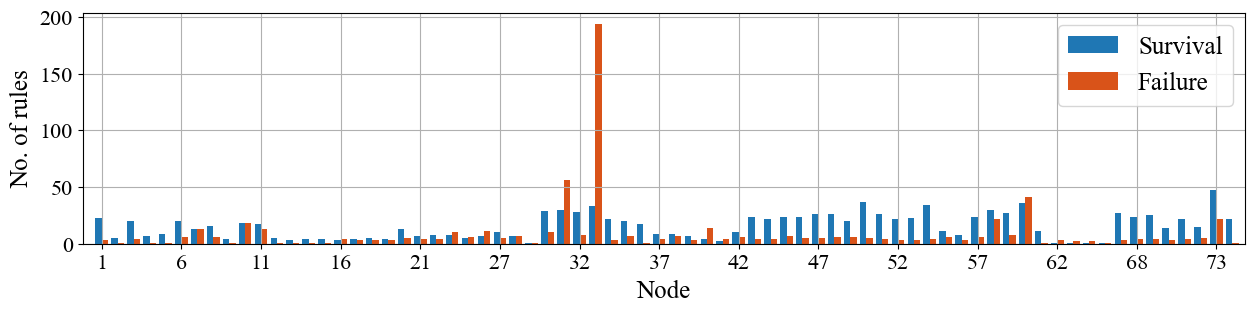

In [11]:
width = 0.8  # the width of the bars
group_width = 2.0  # the width of the bars

mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Times New Roman'

plt.figure()
plt.figure(figsize=(15, 3))

# Plot the first set of data
plt.bar([x * group_width for x in range(len(s_nrules.keys()))], list(s_nrules.values()), width, label='Survival')

# Plot the second set of data
plt.bar([x * group_width + width for x in range(len(f_nrules.keys()))], list(f_nrules.values()), width, label='Failure', color=(0.8500, 0.3250, 0.0980))

# Set x-ticks every 10 labels
keys = [k[1:] for k in s_nrules.keys()]
plt.xticks([x * group_width + width/2 for x in range(0, len(s_nrules), 5)], keys[::5])

plt.xlim(-group_width, len(s_nrules.keys()) * group_width)
plt.legend(fontsize=18)
plt.grid(True)

plt.xlabel('Node', fontsize=18)
plt.ylabel('No. of rules', fontsize=18)

plt.savefig('n_rules.png', dpi=500)
%matplotlib inline
plt.show()

In [12]:
print(s_nrules['n33']+f_nrules['n33'])

227


<Figure size 640x480 with 0 Axes>

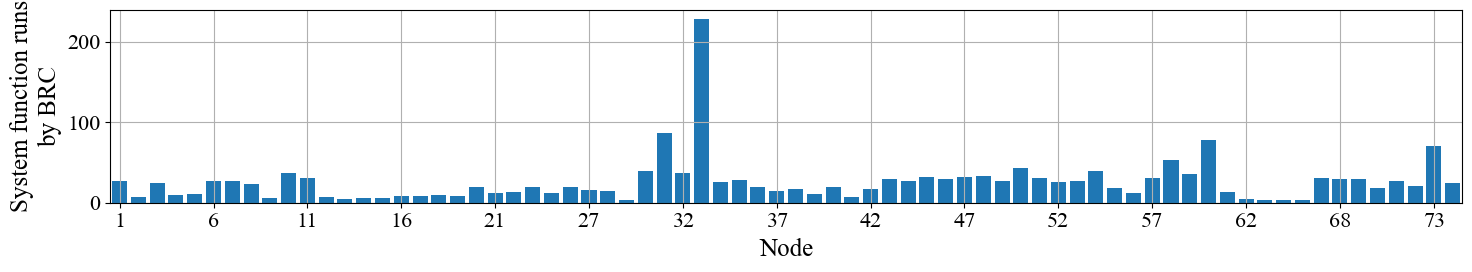

In [13]:
plt.figure()
plt.figure(figsize=(15, 3))

keys = [k[1:] for k in nfuns.keys()]
nfuns_list = [nfuns[k] for k in nfuns.keys()]

plt.bar(range(len(nfuns)), nfuns_list, width, tick_label=keys)
plt.xticks(range(0, len(nfuns), 5))  # Set x-ticks every 5 labels
plt.xlim(-0.5, len(nfuns) - 0.5)

plt.grid(True)

plt.xlabel('Node', fontsize=18)
plt.ylabel('System function runs\nby BRC', fontsize=18)

plt.tight_layout()
plt.savefig('n_funs_brc.png', dpi=500)

%matplotlib inline
plt.show()

In [14]:
print(nfuns['n33'])

228


<Figure size 640x480 with 0 Axes>

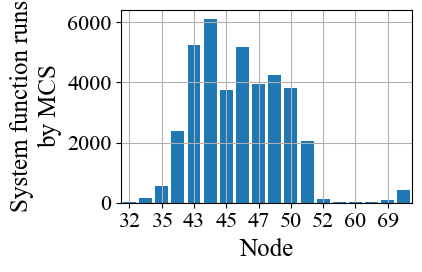

In [15]:
plt.figure()
plt.figure(figsize=(4.5, 3))

keys = [k for k in nfuns.keys() if nsamps[k] > 0]
nfuns_list = [nsamps[k] for k in keys]
keys = [k[1:] for k in keys]

plt.bar(range(len(keys)), nfuns_list, width, tick_label=keys)
plt.xticks(range(0, len(keys),2))  # Set x-ticks every 5 labels
plt.xlim(-0.5, len(keys) - 0.5)

plt.grid(True)

plt.xlabel('Node', fontsize=18)
plt.ylabel('System function runs\nby MCS', fontsize=18)

plt.tight_layout()
plt.savefig('n_funs_mcs.png', dpi=500)

%matplotlib inline
plt.show()

In [16]:
print(nsamps['n44']+nfuns['n44'])

6129


<Figure size 640x480 with 0 Axes>

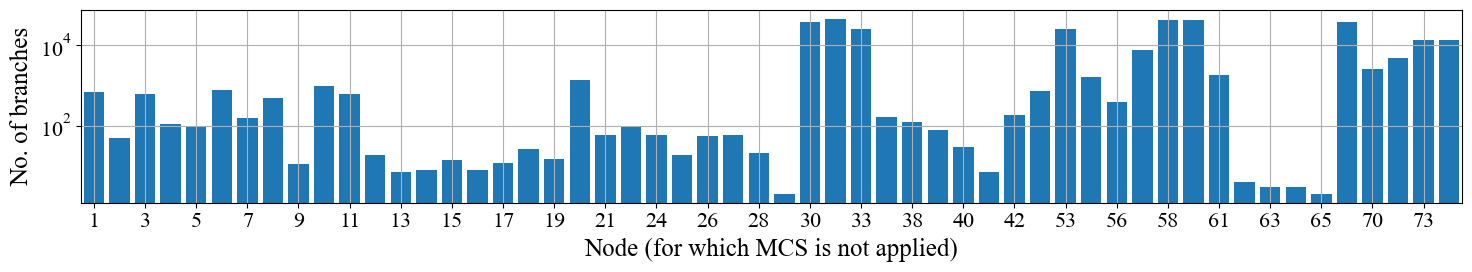

In [17]:
plt.figure()
plt.figure(figsize=(15, 3))

keys = [k for k in nfuns.keys() if nsamps[k] == 0]
nfuns_list = [nbrs[k] for k in keys]
keys = [k[1:] for k in keys]

plt.bar(range(len(keys)), nfuns_list, tick_label=keys)
plt.xticks(range(0, len(keys),2)) 
plt.xlim(-0.5, len(keys) - 0.5)

plt.grid(True)
plt.yscale('log')

plt.xlabel('Node (for which MCS is not applied)', fontsize=18)
plt.ylabel('No. of branches', fontsize=18)

plt.tight_layout()
plt.savefig('n_brs.png', dpi=500)

%matplotlib inline
plt.show()

In [18]:
plt.close('all')

Updated hazard scenario

In [19]:
node_pfs2 = {}
bnds2, covs2, times2 = {}, {}, {}
with open(output_path / "pf_upd.txt") as f:
    for line in f:
        node, pf, bnd, cov, sec = line.strip().split("\t")
        node_pfs2[node], bnds2[node], covs2[node], times2[node] = float(pf), float(bnd), float(cov), float(sec)


C:\Users\jb622s\AppData\Local\Temp\ipykernel_13612\1691066450.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)


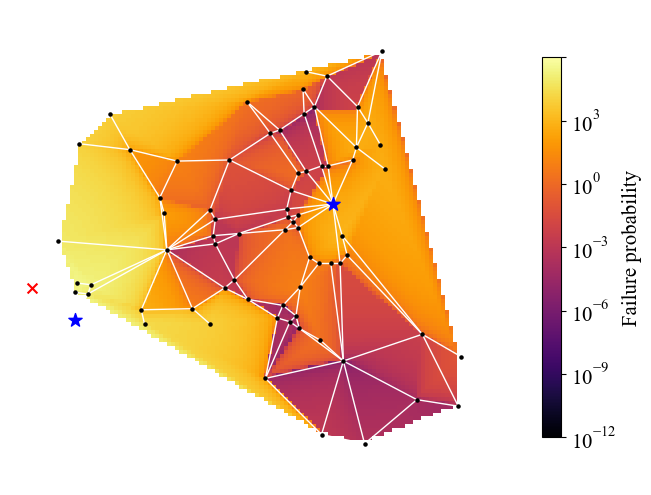

In [20]:
draw_pf_map(node_coords, node_pfs2, arcs, cfg.infra['eq']['s2']['epicentre'], os_list,cfg.infra['eq']['s2']['Mw'], 'pf_map2.png', is_legend = False, is_cmap = True, margin=[-0.2, 1.0, 0.99, 0.0])

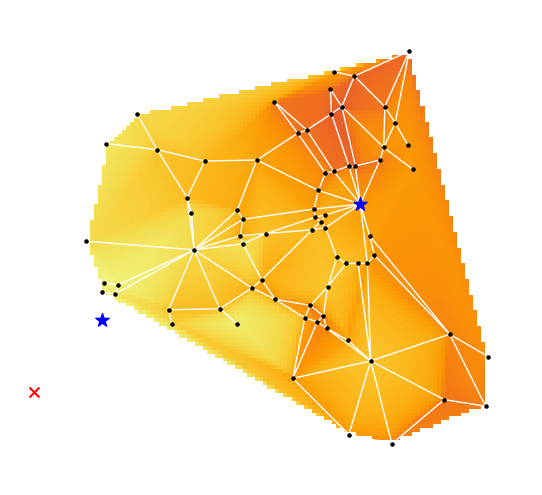

In [21]:
node_pfs1d = {}
bnds1d, covs1d, times1d = {}, {}, {}
with open(output_path / "pf_dep.txt") as f:
    for line in f:
        node, pf, bnd, cov, sec = line.strip().split("\t")
        node_pfs1d[node], bnds1d[node], covs1d[node], times1d[node] = float(pf), bnd, cov, sec

#node_pfs1d['n29'] = node_pfs['n29'] # TODO: check what is wrong with n29 calculation

draw_pf_map(node_coords, node_pfs1d, arcs, cfg.infra['eq']['s1']['epicentre'], os_list,cfg.infra['eq']['s1']['Mw'], 'pf_map1d.png', is_legend = False, is_cmap = False, margin=[-0.2, 1.0, 0.99, 0.0])

In [22]:
node = 'n67'
print(node_pfs[node], node_pfs2[node])

0.018591 0.0060475


In [23]:
node = 'n43'
#print(node_pfs[node], node_pfs1d[node])

with open( output_path / f"rules_{node}.pk", "rb" ) as f:
    rules = pickle.load(f)

print(len(rules['s']), rules['s'])
print(len(rules['f']), rules['f'])

24 [{'e83': 1, 'e75': 1, 'e56': 1, 'e42': 1}, {'e83': 1, 'e77': 1, 'e76': 1, 'e78': 1, 'e44': 1}, {'e86': 1, 'e84': 1, 'e75': 1, 'e56': 1, 'e42': 1}, {'e71': 1, 'e69': 1, 'e55': 1, 'e53': 1, 'e42': 1}, {'e83': 1, 'e75': 1, 'e56': 1, 'e52': 1, 'e50': 1, 'e41': 1}, {'e71': 1, 'e73': 1, 'e70': 1, 'e55': 1, 'e53': 1, 'e42': 1}, {'e71': 1, 'e69': 1, 'e67': 1, 'e66': 1, 'e49': 1, 'e47': 1, 'e41': 1}, {'e85': 1, 'e72': 1, 'e69': 1, 'e55': 1, 'e53': 1, 'e42': 1}, {'e83': 1, 'e75': 1, 'e56': 1, 'e52': 1, 'e48': 1, 'e45': 1, 'e40': 1}, {'e86': 1, 'e90': 1, 'e93': 1, 'e81': 1, 'e44': 1}, {'e83': 1, 'e77': 1, 'e76': 1, 'e78': 1, 'e80': 1, 'e57': 1, 'e43': 1}, {'e86': 1, 'e90': 1, 'e93': 1, 'e79': 1, 'e78': 1, 'e44': 1}, {'e71': 1, 'e73': 1, 'e120': 1, 'e117': 1, 'e125': 1}, {'e85': 1, 'e72': 1, 'e73': 1, 'e70': 1, 'e55': 1, 'e53': 1, 'e42': 1}, {'e85': 1, 'e72': 1, 'e69': 1, 'e67': 1, 'e66': 1, 'e49': 1, 'e47': 1, 'e41': 1}, {'e83': 1, 'e77': 1, 'e74': 1, 'e56': 1, 'e42': 1}, {'e86': 1, 'e90': 1, 

In [24]:
times = {k: v for k, v in brc_times.items()}
for k in mcs_times:
    times[k] += mcs_times[k]

In [25]:
print(times2)

{'n1': 0.4446072578430176, 'n2': 0.04752039909362793, 'n3': 0.4351201057434082, 'n4': 0.08800101280212402, 'n5': 0.06799697875976562, 'n6': 0.5071918964385986, 'n7': 0.14299869537353516, 'n8': 0.2580852508544922, 'n9': 0.017999887466430664, 'n10': 0.652712345123291, 'n11': 0.4631946086883545, 'n12': 0.02699899673461914, 'n13': 0.01600027084350586, 'n14': 0.017000913619995117, 'n15': 0.020035266876220703, 'n16': 0.019036531448364258, 'n17': 0.017000198364257812, 'n18': 0.02299976348876953, 'n19': 0.023049354553222656, 'n20': 0.8826773166656494, 'n21': 0.045000314712524414, 'n23': 0.06000041961669922, 'n24': 0.0410001277923584, 'n25': 0.0279998779296875, 'n26': 0.05100250244140625, 'n27': 0.04703521728515625, 'n28': 0.027000904083251953, 'n29': 0.016031742095947266, 'n30': 22.498977184295654, 'n31': 28.4022216796875, 'n32': 12.809322357177734, 'n33': 16.082128763198853, 'n34': 9.225519180297852, 'n35': 13.959403276443481, 'n36': 26.707013368606567, 'n37': 0.1490020751953125, 'n38': 0.084

<Figure size 640x480 with 0 Axes>

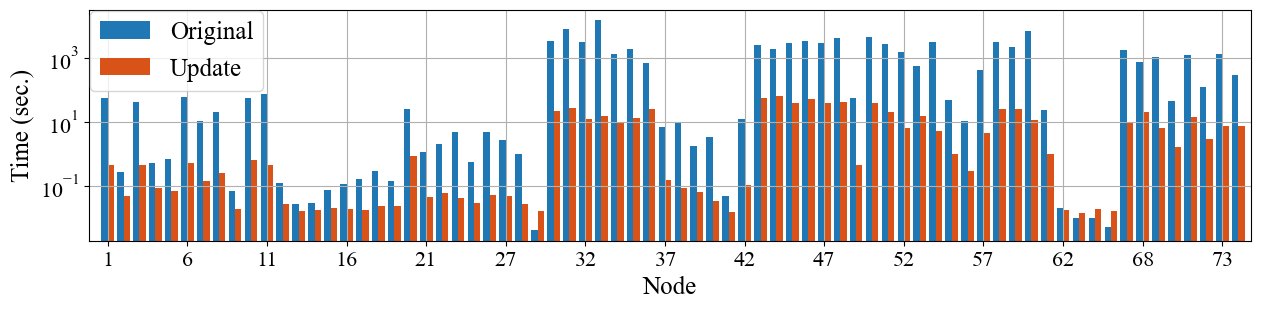

In [26]:
width = 0.8  # the width of the bars
group_width = 2.0  # the width of the bars

mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Times New Roman'

plt.figure()
plt.figure(figsize=(15, 3))

# Plot the first set of data
plt.bar([x * group_width for x in range(len(times.keys()))], list(times.values()), width, label='Original')

# Plot the second set of data
plt.bar([x * group_width + width for x in range(len(times2.keys()))], list(times2.values()), width, label='Update', color=(0.8500, 0.3250, 0.0980))

# Set x-ticks every 10 labels
keys = [k[1:] for k in times.keys()]
plt.xticks([x * group_width + width/2 for x in range(0, len(times), 5)], keys[::5])

plt.xlim(-group_width, len(times.keys()) * group_width)
plt.legend(fontsize=18, bbox_to_anchor=(0.161, 1.049))
plt.grid(True)
plt.yscale('log')

plt.xlabel('Node', fontsize=18)
plt.ylabel('Time (sec.)', fontsize=18)

plt.savefig('times.png', dpi=500)
%matplotlib inline
plt.show()

In [27]:
print(sum([v for v in times.values()])/60, sum([v for v in times2.values()])/60)

1455.6665043480305 11.097931547959645


In [41]:
node = 'n67'
print(times[node], times2[node])

1794.200305376053 9.101605653762817


In [28]:
node_pfs['n1']

2.0946e-08

<Figure size 640x480 with 0 Axes>

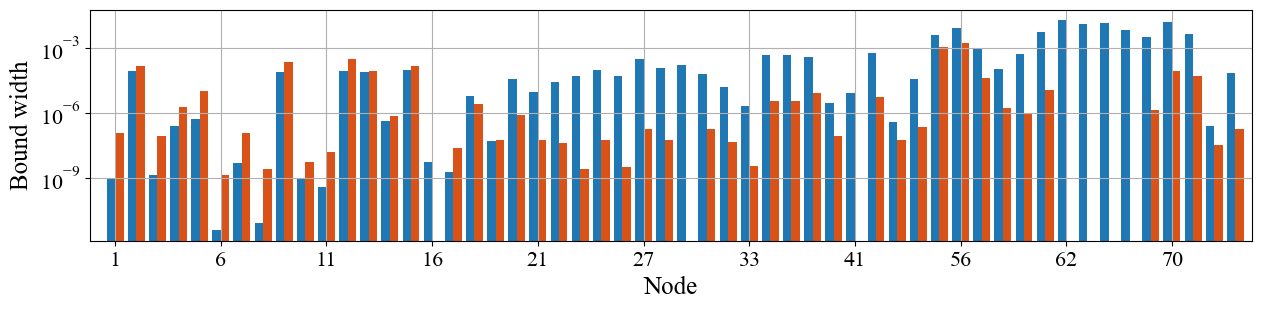

In [29]:
plt.figure()
plt.figure(figsize=(15, 3))

keys = [k for k in bnds2.keys() if nsamps[k] == 0]
vals1 = [0.05*node_pfs[k] for k in keys]
vals2 = [bnds2[k] for k in keys]

# Plot the first set of data
plt.bar([x * group_width for x in range(len(keys))], vals1, width, label='Original')

# Plot the second set of data
plt.bar([x * group_width + width for x in range(len(keys))], list(vals2), width, label='Updated', color=(0.8500, 0.3250, 0.0980))

# Set x-ticks every 10 labels
keys = [k[1:] for k in keys]
plt.xticks([x * group_width + width/2 for x in range(0, len(keys), 5)], keys[::5])

plt.xlim(-group_width, len(keys) * group_width)
#plt.legend(fontsize=18)
plt.grid(True)
plt.yscale('log')

plt.xlabel('Node', fontsize=18)
plt.ylabel('Bound width', fontsize=18)

plt.savefig('bnd_wid.png', dpi=500)
%matplotlib inline
plt.show()

In [30]:
node = 'n64'
print(node_pfs[node], node_pfs2[node], bnds2[node])

0.28396 0.34339 0.0


<Figure size 640x480 with 0 Axes>

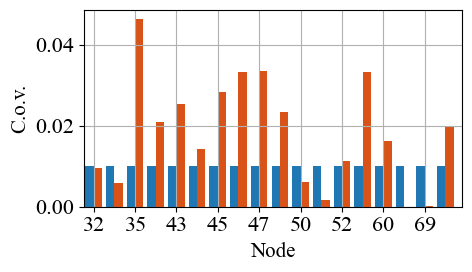

In [31]:
plt.figure()
plt.figure(figsize=(5, 3))

keys = [k for k in bnds2.keys() if nsamps[k] > 0]
vals1 = [0.01 for k in keys]
vals2 = [covs2[k] for k in keys]

# Plot the first set of data
plt.bar([x * group_width for x in range(len(keys))], vals1, width, label='Original')

# Plot the second set of data
plt.bar([x * group_width + width for x in range(len(keys))], list(vals2), width, label='Updated', color=(0.8500, 0.3250, 0.0980))

# Set x-ticks every 10 labels
keys = [k[1:] for k in keys]
plt.xticks([x * group_width + width/2 for x in range(0, len(keys), 2)], keys[::2])

fsz = 15
plt.xlim(-0.5, len(keys) * group_width)
#plt.legend(fontsize=fsz-2, bbox_to_anchor=(0.64, 0.66))
plt.grid(True)
#plt.yscale('log')

plt.xlabel('Node', fontsize=fsz)
plt.ylabel('C.o.v.', fontsize=fsz)

plt.tight_layout()
plt.savefig('cov.png', dpi=500)

%matplotlib inline
plt.show()

In [32]:
node = 'n16'
print(node_pfs[node], node_pfs2[node], bnds2[node])

1.066e-07 3.4059e-06 0.0
